In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base= automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


2016-08-23 00:00:00


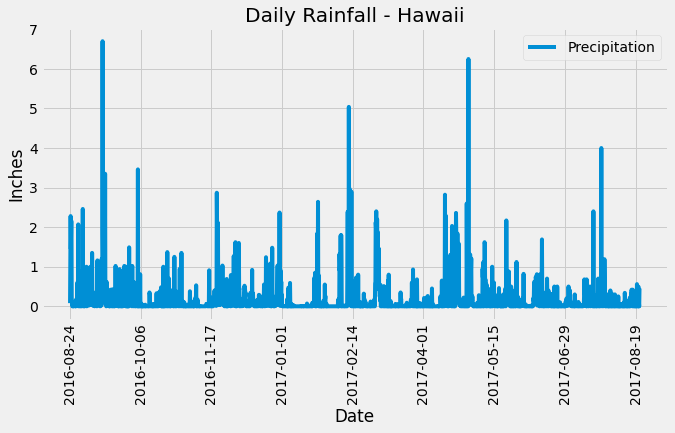

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(most_recent_date[0],'%Y-%m-%d')
start_date = last_date - dt.timedelta(days=365) 
print(start_date)
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
results = session.query(*sel).filter(Measurement.date >= start_date).all()
 
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results, columns=["Date", "Precipitation"])
precipitation_df = precipitation_df.dropna(how = "any")

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()


# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(rot = 90,title = "Daily Rainfall - Hawaii", ylabel = "Inches" , figsize=(10,5))

plt.show()

In [71]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [77]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
print(f'There are {station_count} stations available in this dataset.')

There are 9 stations available in this dataset.


In [109]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.date)]
active_stations = session.query(*sel).\
group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [119]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = "USC00519281"
session.query(func.min(Measurement.tobs),
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs)).filter(Measurement.station == station_id).all()

[(54.0, 85.0, 71.66378066378067)]

In [158]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
      Measurement.tobs]
station_temp = session.query(*sel).\
filter(func.strftime(Measurement.date)>= start_date, Measurement.station == station_id).\
group_by(Measurement.date).\
order_by(Measurement.date).all()

# Create DataFrame to display the results of the query
station_temp_df = pd.DataFrame(station_temp, columns = ["Measurment Date", "tobs"])
station_temp_df.head()


,Measurment Date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


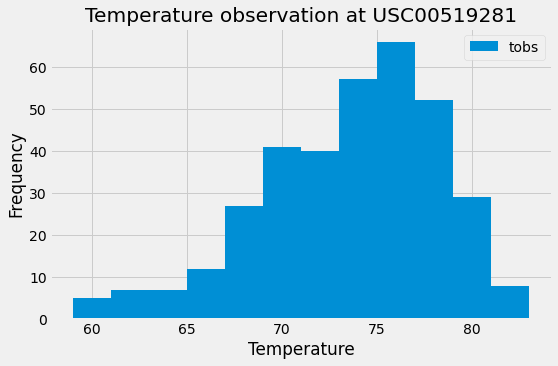

In [190]:
# Ploting the result as a hitogram with bins=12 for the the station that has the greatest number of observations
plt.figure(figsize=(8,5))
plt.hist(station_temp_df["tobs"],bins=12, label="tobs")
plt.title(f"Temperature observation at {station_id}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close session

In [192]:
# Close Session
session.close()